**Universidade de São Paulo**  
**Instituto de Física**  
**Disciplina:** 4305512 - Aprendizado de máquina e inteligência artificial em física  
**Turma:** 2025201  
**Docentes:** Alexandre Alarcon do Passo Suaide, Tiago Fiorini da Silva, Luciana Varanda Rizzo  
**Discente:** Henrique Felix de Souza Machado  
**Nº USP:** 11554214

# Atividade 1

---

## Enunciado

Considere a base de dados contida no arquivo `Stars.csv`, disponível para download na página da disciplina no Moodle, sobre as características observadas de um conjunto de 240 estrelas.

Elabore um código em Python para o processamento desses dados de forma a responder as seguintes questões:

1) Como os dados devem ser preparados para o processamento?

2) Quais as variáveis devem ser reescalonadas e por qual método?

3) Aplique a redução de variáveis pelo método PCA e determine o número de componentes necessárias para se explicar, pelo menos, 90% da variância dos dados.

4) Olhando as três primeiras componentes principais do PCA, quais a variáveis da tabela são mais importantes para o agrupamento dos dados?

5) Utilize o método de agrupamento hierárquico para agrupar as estrelas de acordo com suas características. Qual o número de agrupamentos ideal para análise desses dados?

6) Utilize o método KMeans para agrupar as estrelas de acordo com suas características. Qual o número de agrupamentos ideal para análise desses dados?

7) Utilize o método DBSCAN para agrupar as estrelas de acordo com suas caraterísticas. Qual o número de agrupamentos obtido? Comente sobre a presença ou não de *outliers*.

8) Faça uma análise sobre a performance geral dos algoritmos utilizados nos itens de 5 a 7 comparando com as categorias definidas manualmente e que podem ser encontradas no arquivo `Categorias.csv`.

---

## Proposta de resolução

### 1) Pré-processamento

Nete tópico, abordo simultaneamente as questões 1 e 2.

#### 1.1) Exploração inicial e procura por valores faltantes

Primeiro, vamos importar os dados e fazer uma breve análise exploratória para conhecê-los.

In [155]:
import pandas as pd

dados = pd.read_csv('dados/Stars.csv')
dados.shape

(240, 7)

Vemos que a tabela possui 240 observações. Para verificar se há dados ausentes, ou seja, se algum valor é de tipo `NoneType`, `numpy.NaN`, `pd.NA` ou `NaT`, uso primeiramente o método `isna()`:

In [156]:
dados.isna().sum()

Star              0
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64

Ou seja, não temos valores ausentes no formato específico dessas classes. Vamos conhecer melhor cada coluna para ter certeza disso e explorar ainda mais a base:

In [157]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Star            240 non-null    int64  
 1   Temperature     240 non-null    int64  
 2   L               240 non-null    float64
 3   R               240 non-null    float64
 4   A_M             240 non-null    float64
 5   Color           240 non-null    object 
 6   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


De início, nota-se o mesmo resultado da função `isna()`, contando-se $240$ valores não-nulos em todas as colunas, indicando que pelo menos o preenchimento está completo (podendo ainda haver valores preenchidos, mas que indicam ausência de valor).

Dos tipos das colunas, vemos ainda que há duas colunas com variáveis categóricas (`Color` e `Spectral_Class`), sendo as demais numéricas. Vamos printar a base para olhar os contornos gerais desses dados:

In [158]:
dados

,Star,Temperature,L,R,A_M,Color,Spectral_Class
0,1,3068,0.002400,0.1700,16.12,Red,M
1,2,3042,0.000500,0.1542,16.60,Red,M
2,3,2600,0.000300,102.0000,18.70,Red,M
3,4,2800,0.000200,0.1600,16.65,Red,M
4,5,1939,0.000138,103.0000,20.06,Red,M
...,...,...,...,...,...,...,...
235,236,38940,374830.000000,1356.0000,-9.93,Blue,O
236,237,30839,834042.000000,1194.0000,-10.63,Blue,O
237,238,8829,537493.000000,1423.0000,-10.73,White,A
238,239,9235,404940.000000,1112.0000,-11.23,White,A


Noto que a primeira coluna parece ser apenas uma referência ou identificador de cada estrela, condizente apenas com o número de cada linha da tabela. Para ter certeza, checo se esse é o caso para todos os valores:

In [159]:
sum([(dados['Star'][i]-1) == i for i in range(dados.shape[0])])

np.int64(240)

Ou seja, sim, aparentemente esta coluna é apenas um identificador numérico. Por isso, como primeiro passo na preparação dos dados, julgo adequado **retirar a coluna `Star`**, visto que ela pode passar aos algoritmos de clusterização alguma noção indevida de ordem ou dimensionalidade, interferindo na análise.

In [160]:
dados_tratados = dados.drop(columns='Star')
dados_tratados

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,102.0000,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,103.0000,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


Pelas faixas dos valores de `L`, `R` e `A_M`, conjecturo que podem se tratar dos observáveis físicos comuns em astronomia luminosidade, raio e magnitude absoluta.

Checo agora se algum dos dados numéricos é igual a zero, o que indicaria comportamento potencialmente não físico e me levaria a crer que se trata de valor faltante:

In [161]:
(dados_tratados.iloc[:,0:4] == 0).any()

Temperature    False
L              False
R              False
A_M            False
dtype: bool

Não há zeros, o que é mais um indicativo de que os valores estão corretamente preenchidos para essas colunas.

Agora verifico os valores preenchidos nas colunas categóricas:

In [162]:
# estoca lista com os valores unicos de cada coluna categorica
valores_Color = list(set(dados_tratados['Color']))
valores_SC = list(set(dados_tratados['Spectral_Class']))

# auxiliares para imprimir lado-a-lado
largura_impressao_Color = max([len(x) for x in valores_Color]) + 3
largura_impressao_SC = max([len(x) for x in valores_SC]) + 2

# impressao
print('Valores presentes em...')
print()
print('Color:' + ' ' * 18 + 'Spectral_Class:')
for i in range(max(len(valores_Color), len(valores_SC))):
    try:
        v1 = valores_Color[i]
    except:
        v1 = ' '    
    try:
        v2 = valores_SC[i]
    except:
        v2 = ' '
    print(f'  {v1:<{largura_impressao_Color}} {v2:>{largura_impressao_SC}}')

Valores presentes em...

Color:                  Spectral_Class:
  Blue White              G
  Pale yellow orange      K
  Blue                    M
  Yellowish               B
  yellow-white            O
  White                   A
  Orange-Red              F
  Blue white               
  Blue-white               
  Whitish                  
  yellowish                
  Orange                   
  Blue-White               
  white                    
  White-Yellow             
  Yellowish White          
  Red                      


Não parece haver valores sem significado, nem espaços em branco, traços, pontos, ou quaisquer valores que poderiam denotar ausência de dados. Pelo contrário, todos os dados dessas colunas têm significado físico. Isso conclui a minha verificação exploratória sobre valores faltantes: ao que tudo indica, **a base de dados fornecida parece estar completa, sem dados faltantes, sendo desnecessário qualquer pré-processamento para endereçar esse tipo de situação**.

#### 1.2) Manejo das variáveis categóricas

Ao realizar esta última verificação, podemos notar um problema em uma das colunas categóricas. Enquanto a coluna `Spectral_Class` encaixa-se perfeitamente no sistema de classes espectrais (*Harvard Spectral Classification*), a coluna `Color` tem duas limitações:
* despadronização: contém alguns pares de valores que deveriam ser tratados como iguais, mas apresentam variações, como tipo de letra (maíscula/minúscula), presença ou ausência de hífen, e sufixo
* subjetividade: não há indício de que a coluna tenha sido preenchida usando-se critérios objetivos, tais como frequência da radiação emitida, pelo contrário, há indícios de que o preenchimento foi feito de maneira adhocrática e subjetiva

Em um primeiro momento, pensei em endereçar o primeiro problema promovendo uma certa padronização, usando um dicionário tal como o seguinte:

In [163]:
Color_dict = {
    'Whitish': 'white',
    'Red': 'red',
    'Yellowish White': 'yellow white',
    'Blue': 'blue',
    'White': 'white',
    'Blue-white': 'blue white',
    'Yellowish': 'yellow',
    'Pale yellow orange': 'pale yellow orange',
    'Orange-Red': 'orange red',
    'Blue white': 'blue white',
    'Blue-White': 'blue white',
    'yellowish': 'yellow',
    'white': 'white',
    'Orange': 'orange',
    'Blue White': 'blue white',
    'White-Yellow': 'yellow white',
    'yellow-white': 'yellow white'
}

No entanto, ficou cada vez mais claro que isso não seria ideal. Primeiro, a falta de padronização pode ser indício de inconsistência entre diferentes bases de dados. Segundo, ao tentar igualar categorias como `Whitish`, `yellowish` ou `Yellowish White` às repesctivas contrapartes `white`, `yellow` ou 
`yellow white`, a subjetividade fica ainda mais clara. Afinal, há vários caminhos em paletas bidimensionais pelas quais o olho humano consegue chegar até uma cor. O amarelo, por exemplo, pode ser obtido continuamente do branco, do laranja, do marrom, ou até mesmo de verdes-azulados. Assim, seria correto categorizar `yellowish` (amarelado) como `yellow` (amarelo)? Poderiam `yellowish` e `yellow` ter vindo de uma mesma base de dados, de modo que deveriam ser classificados de outra foram? Teriam sido fruto de medição física/experimental, ou apenas uma categorização realmente individual, para mera referência ou facilitação? Ao fazer uma breve pesquisa em bases de artigos acadêmicos e manuais de astronomia, não encontrei convenções sobre nomes de cores, apenas sobre classes espectrais.

Ante esses problemas, considero que seria inadequado manter essa categoria na base. O fato de haver na base outros dados objetivos que sabemos ser fortemente correlacionados com a radiação emitida (`Temperature` e `Spectral_Class`) faz com que a coluna `Color` tenha mais o potencial de introduzir ruído que informação, sendo possível recuperar qualquer informação por ela trazida por meio desses outros dados. Equacionar a transformação de `Color` em tipo numérico só confirma essa constatação: por um lado, usar zeros e uns por meio do `OneHotEncoder` introduziria várias dimensões a mais na base, dificultando muito o trabalho dos algoritmos de clusterização; por outro, usar uma escala numérica seria recair em uma inferência muito forte em vista dos vários problemas comentados acima.

Deste modo, **como próximo passo da etapa de pré-processamento, decido eliminar a coluna `Color`**:

In [164]:
dados_tratados = dados_tratados.drop(columns='Color')
dados_tratados


,Temperature,L,R,A_M,Spectral_Class
0,3068,0.002400,0.1700,16.12,M
1,3042,0.000500,0.1542,16.60,M
2,2600,0.000300,102.0000,18.70,M
3,2800,0.000200,0.1600,16.65,M
4,1939,0.000138,103.0000,20.06,M
...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,O
236,30839,834042.000000,1194.0000,-10.63,O
237,8829,537493.000000,1423.0000,-10.73,A
238,9235,404940.000000,1112.0000,-11.23,A


Agora passemos à coluna `Spectral_Class`. Pelos argumentos acima, não há dúvida sobre a decisão de manter essa coluna. A questão aqui passa a ser como transformá-la em variável numérica. É fato que a classe espectral é uma mera classificação que pode compreender toda uma faixa numérica. Não obstante, nesse caso, existe sim uma relação de ordem implícita entre as categorias. Acredito que usar o `OneHotEncoder()` nesse caso pode contribuir para uma proliferação indevida de categorias, pois estaríamos informando ao algoritmo que se tratam de características qualitativamente distintas, quando na verdade são meras bandas de uma mesma escala. Julguei preferível pagar o preço de uma imprecisão numérica em prol da fidelidade ontológica.

Assim, a próxima etapa de pré-processamento foi a **transformação da coluna categórica `Spectral_Class` em números ordenados**, para o que usei o seguinte dicionário:

In [165]:
sc_dict = {
    'M': 1,
    'K': 2,
    'G': 3,
    'F': 4,
    'A': 5,
    'B': 6,
    'O': 7
}

dados_tratados['Spectral_Class'] = [sc_dict[sc] for sc in dados_tratados['Spectral_Class']]
dados_tratados

,Temperature,L,R,A_M,Spectral_Class
0,3068,0.002400,0.1700,16.12,1
1,3042,0.000500,0.1542,16.60,1
2,2600,0.000300,102.0000,18.70,1
3,2800,0.000200,0.1600,16.65,1
4,1939,0.000138,103.0000,20.06,1
...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,7
236,30839,834042.000000,1194.0000,-10.63,7
237,8829,537493.000000,1423.0000,-10.73,5
238,9235,404940.000000,1112.0000,-11.23,5


Vale mencionar que a categoria `Spectral_Class` é uma escala cujas médias de cada faixa são mais ou menos bem ajustadas como uma escala logarítmica, embora não tenha sido criada com esse intuito. Realizei testes com os algoritmos de clusterização aplicados adiante escalonando os valores do dicionário acima para logaritmo, mas o resultado não se alterou. Assim, julguei que essa alteração seria desnecessária e mantive a relação linear de distância apresentada acima.

#### 1.3) Reescalonamento

Agora vamos estudar as colunas originalmente numéricas, para fins de reescalonamento.

In [166]:
nome_colunas_numericas = ['Temperature', 'L', 'R', 'A_M']
df_colunas_numericas = dados_tratados[nome_colunas_numericas]
df_colunas_numericas.describe()

,Temperature,L,R,A_M
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107200.578572,415.982944,121.369458
std,9552.425037,179424.946945,963.239600,2089.328079
min,1939.000000,0.000080,0.008400,-7346.000000
25%,3344.250000,0.000865,0.195025,-6.342500
50%,5776.000000,7.960000,18.000000,10.515000
75%,15055.500000,198050.000000,277.500000,14.097500
max,40000.000000,849420.000000,6237.000000,14776.000000


As estatísticas básicas acima já nos mostram que os dados apresentam enorme variabilidade, com desvios padrão próximos ou até maiores que a própria média. Também apresentam forte tendenciosidade, com médias substancialmente acima das medianas (linha de nome $50%$). Por fim, apresentam escalas e ordens de magnitude bastante diferentes. Tudo isso nos sugere a necessidade de reescalonamento. Para visualizar onde os dados de cada variável se concentram, vamos plotar os histogramas das variáveis:

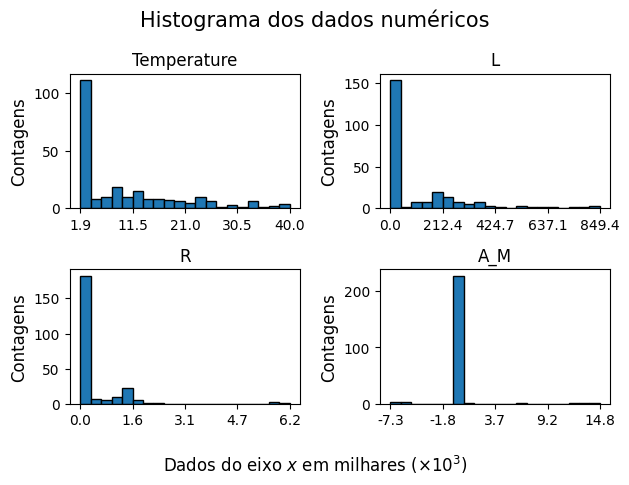

In [167]:
from matplotlib import pyplot as plt
import numpy as np

fig, axes = plt.subplots(2,2)

for i, axis in enumerate(axes.flatten()):
    nome = nome_colunas_numericas[i]
    valores = df_colunas_numericas[nome]
    axis.hist(valores, bins=20, edgecolor='black')
    axis.set_title(nome)
    axis.set_ylabel('Contagens', size=12)
    x_ticks = np.linspace(valores.min(), valores.max(),5)
    axis.set_xticks(x_ticks)
    axis.set_xticklabels(np.round(x_ticks/10**3,1))

fig.suptitle('Histograma dos dados numéricos', size=15)
fig.supxlabel(r'Dados do eixo $x$ em milhares ($\times 10^3$)')

plt.tight_layout()

(Obs.: como não foram fornecidas unidades de medida, escolho não exibir nenhuma unidade em nenhum dos gráficos deste trabalho.)

Como os dados apresentam tanta tendenciosidade e concentração, principalmente na região próxima de zero, acredito que aplicar funções como `MinMaxScaler()` ou `StandardScaler()` de imediato pode dificultar a correta diferenciação dos valores nessa região por parte dos modelos. Assim, tento primeiro **colocar os dados positivos (`Temperature`, `L` e `R`) em escala logarítmica**. **Já para `A_M`**, tendo em vista a existência de valores negativos, tento primeiro **aplicar uma raiz ímpar (cúbica)**:

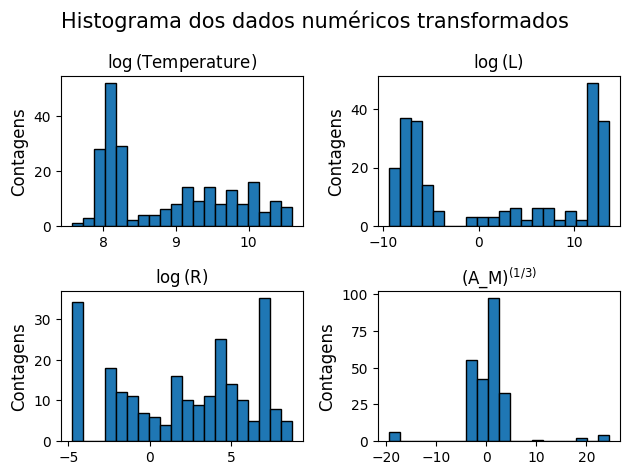

In [168]:
fig, axes = plt.subplots(2,2)

for i, axis in enumerate(axes.flatten()):
    nome = nome_colunas_numericas[i]
    valores = df_colunas_numericas[nome]
    if nome == 'A_M':
        dados_plot = np.cbrt(valores)
        titulo = '(' + nome + r')$^{(1/3)}$'
    else:
        dados_plot = np.log(valores)
        titulo = r'$\log$(' + nome + ')'
    axis.hist(dados_plot, bins=20, edgecolor='black')
    axis.set_title(titulo)
    axis.set_ylabel('Contagens', size=12)

fig.suptitle('Histograma dos dados numéricos transformados', size=15)

plt.tight_layout()

Neste formato, me parece que os dados foram substancialmente desconcentrados, o que acredito pode facilitar a diferenciação por parte do algoritmo. Vamos consolidar essas mudanças na tabela de dados:

In [169]:
dados_tratados[['Temperature', 'L', 'R']] = np.log(dados_tratados[['Temperature', 'L', 'R']])
dados_tratados['A_M'] = np.cbrt(dados_tratados['A_M'])
dados_tratados


,Temperature,L,R,A_M,Spectral_Class
0,8.028781,-6.032287,-1.771957,2.526126,1
1,8.020270,-7.600902,-1.869505,2.550954,1
2,7.863267,-8.111728,4.624973,2.654283,1
3,7.937375,-8.517193,-1.832581,2.553513,1
4,7.569928,-8.888257,4.634729,2.717129,1
...,...,...,...,...,...
235,10.569777,12.834228,7.212294,-2.149396,7
236,10.336535,13.634039,7.085064,-2.198760,7
237,9.085797,13.194671,7.260523,-2.205633,5
238,9.130756,12.911494,7.013915,-2.239374,5


Como segundo passo do reescalonamento, procedo à **normalização dos dados**. Julgo mais adequado **aplicar o `MinMaxScaler()` para as grandezas positivas e o `StandardScaler()` para as que admitem valor negativo**:

In [170]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()

dados_tratados[['Temperature', 'L', 'R', 'Spectral_Class']] = mm_scaler.fit_transform(dados_tratados[['Temperature', 'L', 'R', 'Spectral_Class']])
dados_tratados['A_M'] = std_scaler.fit_transform(dados_tratados[['A_M']])
dados_tratados

,Temperature,L,R,A_M,Spectral_Class
0,0.151602,0.147329,0.222490,0.375831,0.000000
1,0.148790,0.079381,0.215273,0.380760,0.000000
2,0.096917,0.057254,0.695713,0.401276,0.000000
3,0.121402,0.039691,0.218005,0.381268,0.000000
4,0.000000,0.023617,0.696435,0.413754,0.000000
...,...,...,...,...,...
235,0.991127,0.964563,0.887115,-0.552482,1.000000
236,0.914065,0.999209,0.877703,-0.562283,1.000000
237,0.500831,0.980177,0.890682,-0.563648,0.666667
238,0.515685,0.967910,0.872439,-0.570347,0.666667


Com essas operações, considero que o pré-processamento terminou.

---

### 2) Redução de dimensionalidade

Neste tópico, abordo as questões 3 e 4.

#### 2.1) Inicialização

Primeiramente, vamos inicializar o PCA e visualizar a dispersão dos dados entre os dois componentes mais explicativos:

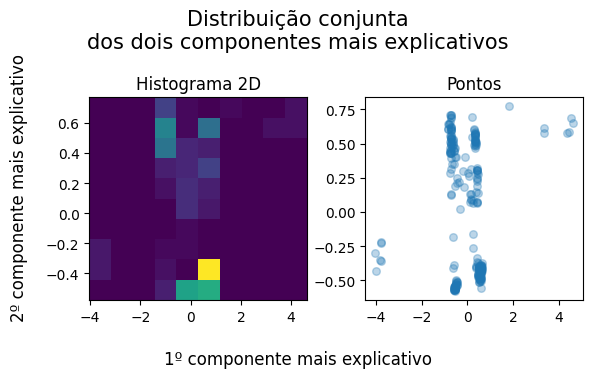

In [171]:
from sklearn.decomposition import PCA

# iniciando o PCA para obter metricas de explicabilidade
pca = PCA()
pca.fit(dados_tratados)
dados_pca = pca.transform(dados_tratados)

# setup do plot
fig, axes = plt.subplots(1,2, figsize=(6,3.7))
x = dados_pca[:,0]
y = dados_pca[:,1]

# histograma
axes[0].hist2d(x, y)
axes[0].set_title('Histograma 2D')

axes[1].scatter(x, y, s=30, alpha=.3)
axes[1].set_title('Pontos')
fig.supxlabel('1º componente mais explicativo', size=12)
fig.supylabel('2º componente mais explicativo', size=12)
fig.suptitle('Distribuição conjunta\ndos dois componentes mais explicativos', size=15)
plt.tight_layout()

Apesar de uma maior concentração em certas regiões, vemos que há dispersão suficiente para propiciar uma classificação.

#### 2.2) Determinação dos componentes principais

Vamos agora usar a explicabilidade acumulada para checar o número de componentes que explicam 90% da variância dos dados:

In [172]:
# calculando explanabilidade acumulada
explicabilidade = pca.explained_variance_ratio_.cumsum()

# definindo um iterador para percorrer a explicabilidade acumulada
def expl_cum_gen():
    for e in explicabilidade:
        yield e

# lista de fatores
fatores = list(range(1, dados_tratados.shape[1]+1))

# loop para percorrer a explicabilidade acumulada
# (fator_90 estoca o primeiro numero que explica mais que 90%)
gen = expl_cum_gen()
expl_cum = next(gen) # equivale a expl_cum = explicabilidade[0]
fator_90 = 1 # ja inicio em 1 porque queremos o proximo fator depois de 90%
while expl_cum < 0.9:
    expl_cum = next(gen)
    fator_90 += 1

O número desejado está na variável `fator_90` definida acima. Visualizando:

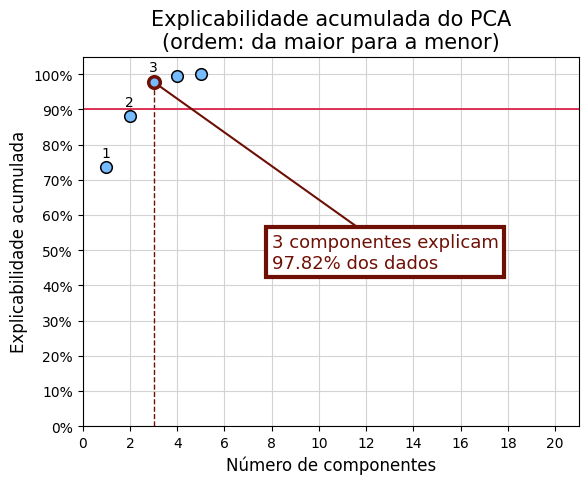

In [173]:
# pontos
plt.scatter(fatores, explicabilidade, color='xkcd:sky blue', zorder=3, edgecolors='black', linewidths=1.1, s=70)

# eixos
plt.yticks(np.array(range(0,11))/10, [str(x) + '%' for x in list(range(0,101,10))])
plt.xticks(list(range(0,21,2)))
plt.xlim(0, 21)
plt.ylim(0,1.05)

# titulos
plt.title('Explicabilidade acumulada do PCA\n(ordem: da maior para a menor)', size=15)
plt.xlabel('Número de componentes', size=12)
plt.ylabel('Explicabilidade acumulada', size=12)

# indicacao do menor numero de componentes >90%
cor_fator_90 = 'xkcd:reddy brown'
plt.vlines(fator_90, 0, expl_cum, colors=cor_fator_90, linewidth=1, linestyles='--')
plt.text(8, 0.45, f'{fator_90} componentes explicam\n{round(expl_cum*100, 2)}% dos dados', color=cor_fator_90,  fontsize=13, bbox={'facecolor': 'white', 'edgecolor': cor_fator_90, 'linewidth': 3}, zorder=6)
plt.scatter(fator_90, expl_cum, color='xkcd:sky blue', edgecolors=cor_fator_90, linewidths=2.5, zorder=5, s=70)
plt.plot([fator_90, 13], [expl_cum, .5], color=cor_fator_90, zorder=4)

# sarrafo
plt.hlines(0.9, -0, 21, colors='crimson', linewidth=1.2)

# grade
plt.grid(True, which='major', zorder=0, color='lightgrey')

# indicacao do numero acumulado de componentes sobre os primeiros pontos, para auxiliar o leitor
for i in range(0,fator_90):
    plt.text(fatores[i]-0.2, explicabilidade[i]+0.03, str(fatores[i]), size=10, zorder=3)

Ou seja, das 5 colunas que restaram após o pré-processamento, **3 componentes é o conjunto mínimo para explicar 90% da variância dos dados**. **Em ordem inversa de explicabilidade (da maior para a menor), as 3 primeiras variáveis são responsáveis por cerca de 98% da variância dos dados**.

De posse dessa informação, rodamos abaixo o PCA especificando o argumento `n_components`:

In [174]:
pca = PCA(n_components=fator_90)
pca.fit(dados_tratados)
dados_pca = pca.transform(dados_tratados)

#### 2.3) Recuperando as variáveis mais importantes

Vale lembrar que cada componente principal é uma combinação linear das variáveis originais. Ou seja, para cada componente, cada variável original possui um respectivo coeficiente em uma soma linear. Este coeficiente nos dá o peso daquela variável para a determinação daquele componente.

Para recuperar quais variáveis originais explicam os 3 componentes escolhidos, podemos usar a matriz `PCA().components_` fornecida pelo Scikit-Learn, que estoca os coeficientes nas colunas e os componentes nas linhas. Ou seja, no nosso caso, uma matriz $3 \times 5$:

In [175]:
pca.components_.shape

(3, 5)

Peguemos as três primeiras componentes e recuperemos o respectivo maior coeficiente. Uso o objeto `Series` do `pandas` para manter o registro da coluna original (variável original) após fazer o ordenamento. Visto que os coeficientes podem ser negativos, é necessário usar seu valor absoluto.:

In [176]:
variaveis_originais = []
print('Variáveis mais importantes para os 3 principais componentes:')
print('Componente    Variável')
for i in range(3):
    var = pd.Series(abs(pca.components_[i])).sort_values(ascending=False).index[0]
    variaveis_originais.append(var)
    print(f'     {i+1}        {dados_tratados.columns[var]}')


Variáveis mais importantes para os 3 principais componentes:
Componente    Variável
     1        A_M
     2        Spectral_Class
     3        L


Notamos que **as variáveis mais importantes para os 3 principais componentes são: a magnitude absoluta (`A_M`), a classe espectral (`Spectral_Class`) e luminosidade (`L`)**.

---

### 3) Clusterização

Neste tópico, abordo as questões 5, 6 e 7.

#### 3.1) Método empregado e funções auxiliares

O procedimento geral que realizarei para cada um dos três algoritmos de clusterização será o mesmo:
1. um loop para aplicar o algoritmo variando seus parâmetros
2. análise de silhueta de cada conjunto de parâmetros, elegendo uma única classificação
3. plots para ajudarem na visualização da classificação escolhida

Como métricas, usamos o fator de silhueta, o percentual de mal classificados (percentual de pontos cujo score individual de silhueta foi negativo), e o indicador de performance, que divide a primeira métrica pela segunda.

Como será uma tarefa repetitiva, defino abaixo rotinas auxiliares para serem reutilizadas adiante:
* função `aplicar_algoritmo()` aplica algum dos três algoritmos ao conjunto de dados conforme um conjunto de parâmetros, retornado as classificações do algoritmo
* função `aplicar_algoritmo_em_range()` aplica um mesmo algoritmo conforme vários conjuntos de parâmetros, passando adiante o retorno da função anterior para todos esses conjuntos
* função `pegar_silhuetas()` retorna o fator de silhueta e os números individuais de silheta para cada conjunto de parâmetros (i.e., para todo o retorno consolidado da função anterior)
* função `metricas_silhuetas()` retorna as principais métricas deriváveis dos indicadores da função anterior para cada conjunto de parâmetros, retornando uma tabela que permite comparar entre os diferentes conjuntos
* função `plotar_clustering()` plota uma visualização dos pontos de acordo com as 3 variáveis mais importantes definidas acima, conforme o reescalonamento (para melhor visualização)

In [177]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

def aplicar_algoritmo(algoritmo, dados, n_clusters=None, eps=None, min_samples=None):
    """
    Aplica o algoritmo escolhido sobre a tabela de dados, de acordo com um
    único conjunto de parâmetros.
    Retorna a lista de categorias classificadas pelo algoritmo.
    """
    # seleciona o algoritmo escolhido, definindo os parametros adequados
    match algoritmo:
        case 'KMeans':
            parametros = {'n_clusters': n_clusters, 'init': 'k-means++', 'n_init': 'auto', 'random_state': 13}
        case 'AgglomerativeClustering':
            parametros = {'n_clusters': n_clusters, 'linkage': 'ward'}
        case 'DBSCAN':
            parametros = {'eps': eps, 'min_samples': min_samples}
    # aplica o algoritmo
    codigo_fit = algoritmo + '(**parametros).fit(dados)'
    obj_modelo = eval(codigo_fit)
    return obj_modelo.labels_

def aplicar_algoritmo_em_range(algoritmo, dados, range_dict):
    """
    Aplica o algorito escolhido sobre a tabela de dados várias vezes,
    para cada conjunto de parâmetros no range fornecido.
    O argumento 'range_dict' é um dicionário cujas chaves são os nomes dos
    parâmetros a serem passados ao modelo e cujos valores são, no caso de 
    KMeans ou AgglomerativeClustering, duplas com o início e fim (inclusivo)
    do range a ser aplicado ou, no caso do DBSCAN, tupla contendo também o
    passo do range.
    Retorna um dict com o conjunto de parâmetros aplicados como chave
    e o respectivo retorno da função aplicar_algoritmo como valor.
    """
    dict_classificacoes = {}
    match algoritmo:
        case 'KMeans' | 'AgglomerativeClustering':
            range_aplicacao = range(range_dict['n_clusters'][0], range_dict['n_clusters'][1]+1)
            for n in range_aplicacao:
                dict_classificacoes[n] = aplicar_algoritmo(algoritmo, dados, n)
        case 'DBSCAN':
            range_aplicacao_eps = np.arange(range_dict['eps'][0], range_dict['eps'][1], range_dict['eps'][2])
            range_aplicacao_min_samples = range(range_dict['min_samples'][0], range_dict['min_samples'][1]+1, range_dict['min_samples'][2])
            for e in range_aplicacao_eps:
                for ms in range_aplicacao_min_samples:
                    chave = 'e=' + str(round(e,1)) + ';ms=' + str(ms)
                    dict_classificacoes[chave] = aplicar_algoritmo(algoritmo, dados, None, e, ms)
    
    return dict_classificacoes


def pegar_silhuetas(dict_classificacoes, dados):
    """
    Recebe o retorno da função aplicar_algoritmo_em_range e pega os valores
    de silhueta de cada um, tanto média quanto das observações.
    Retorna dict com esse resultado, usando a mesma chave do dict fornecido.
    """
    dict_silhuetas = {}
    for chave, valor in dict_classificacoes.items():
        score = silhouette_score(dados, valor)
        samples = silhouette_samples(dados, valor)
        dict_silhuetas[chave] = (score, samples)
    return dict_silhuetas


def metricas_silhuetas(dict_silhuetas, algoritmo, dict_classificacoes_DBSCAN=None):
    """
    Recebe o resultado da análise de silhuetas e consolida as principais métricas
    em um DataFrame.
    Também printa um gráfico com as linhas desse DataFrame.
    Quando o algoritmo for o DBSCAN, deve-se fornecer as classificações ao argumento
    'dict_classificacoes_DBSCAN', para exibir a contagem de clusters.
    """
    # construcao do DataFrame
    nomes_parametros = [chave for chave in dict_silhuetas]
    fator_silhueta = [item[0] for item in dict_silhuetas.values()]
    perc_mal_classificados = [100 * (item[1] < 0).sum() / item[1].shape[0] for item in dict_silhuetas.values()]
    metrica_performance = np.array(fator_silhueta) / np.array(perc_mal_classificados)

    metricas = pd.DataFrame({
        'Parâmetros': nomes_parametros,
        'Fator': fator_silhueta,
        '% mal class.': perc_mal_classificados,
        'Performance': metrica_performance
    })

    # administra particularidades de cada analise conforme o algoritmo
    if algoritmo == 'DBSCAN': # para DBSCAN, adiciona colunas p/ contar clusters e outliers
        is_dbscan = True
        metricas['Nº clusters'] = [len(set(classificacao) - {-1}) for classificacao in dict_classificacoes_DBSCAN.values()]
        metricas['Nº outliers'] = [(classificacao == -1).sum() for classificacao in dict_classificacoes_DBSCAN.values()]
        nome_eixo_x = r'Dupla de parâmetros ($\epsilon$, min_samples)'
    else: 
        is_dbscan = False
        metricas = metricas.rename(columns={'Parâmetros': 'Nº clusters'})
        nome_eixo_x = 'Nº clusters'

    # plota
    fig, axes = plt.subplots(1,3, figsize=(7,3))
    for i in range(1,4):
        axes[i-1].plot(nomes_parametros, metricas.iloc[:,i])
        axes[i-1].set_title(metricas.columns[i])
        if is_dbscan: # se for DBSCAN
            # variavel abaixo apenas coloca os parametros em formato de dupla (e,ms)
            # para permitir visualizacao no eixo x
            xticklabels = ['(' + t.split('=')[1].split(';')[0] + ',' + t.split('=')[2] + ')' for t in nomes_parametros]
            axes[i-1].set_xticks(nomes_parametros[::3])
            axes[i-1].set_xticklabels(xticklabels[::3], rotation=90)
            axes[i-1].set_xticks(nomes_parametros, minor=True)
            axes[i-1].tick_params(axis='x', which='minor', length=2)
            axes[i-1].tick_params(axis='x', which='major', length=5)

    fig.suptitle(f'Análise de silhueta do algoritmo {algoritmo}\nem função dos parâmetros', size=15)
    fig.supxlabel(nome_eixo_x)
    plt.tight_layout()
    return metricas

def plotar_clustering(classificacao, algoritmo, elev=35, azim=60):
    """
    Plota a classificação dada (um dos elementos do dicionário retornado pela função
    aplicar_algoritmos).
    Argumento 'algoritmo' deve ser string a ser disposta no título do gráfico.
    Argumentos 'elev' e 'azim' são repassados à função de plot 3D.
    """
    fig, axes = plt.subplots(2,2,figsize=(6,6.3))
    fig.suptitle('Clusterização ideal para o ' + algoritmo, size=15)
    fig.supxlabel('Obs.: todas as grandezas estão em unidades reescalonadas\npara melhorar a visualização')

    axes[0,0].scatter(dados_tratados['A_M'], dados_tratados['Spectral_Class'], c=classificacao, cmap='tab10')
    axes[0,0].set_xlabel('1. Magnitude Absoluta (AM)')
    axes[0,0].set_ylabel('2. Classe Espectral (CE)')

    axes[0,1].scatter(dados_tratados['Spectral_Class'], dados_tratados['L'], c=classificacao, cmap='tab10')
    axes[0,1].set_xlabel('2. Classe Espectral (CE)')
    axes[0,1].set_ylabel('3. Luminosidade (L)')

    axes[1,0].scatter(dados_tratados['A_M'], dados_tratados['L'], c=classificacao, cmap='tab10')
    axes[1,0].set_xlabel('1. Magnitude Absoluta (AM)')
    axes[1,0].set_ylabel('3. Luminosidade')

    axis3d = fig.add_subplot(224, projection='3d')
    axis3d.scatter3D(dados_tratados['A_M'], dados_tratados['Spectral_Class'], dados_tratados['L'], c=classificacao, cmap='tab10')
    axis3d.view_init(elev, azim)
    axis3d.set_xlabel('1. AM')
    axis3d.set_ylabel('2. CE')
    axis3d.set_zlabel('3. L')
    fig.delaxes(axes[1,1])

    # excecao para plotar outliers do DBSCAN
    if algoritmo == 'DBSCAN':
        df_outliers = dados_tratados[classificacao == -1]
        axes[0,0].scatter(df_outliers['A_M'], df_outliers['Spectral_Class'], color='xkcd:deep orange', marker='x', s=70, label='Outliers')
        axes[0,1].scatter(df_outliers['Spectral_Class'], df_outliers['L'], color='xkcd:deep orange', marker='x', s=70)
        axes[1,0].scatter(df_outliers['A_M'], df_outliers['L'], color='xkcd:deep orange', marker='x', s=70)
        axis3d.scatter3D(df_outliers['A_M'], df_outliers['Spectral_Class'], df_outliers['L'], color='xkcd:deep orange', marker='x', s=70)
        fig.legend(loc="upper right")

    plt.tight_layout()

#### 3.2) Hierárquico

O algoritmo Hierárquico, dado pela função `AgglomerativeClustering` do ScikitLearn, recebe como principal parâmetro o número de clusters que queremos impor. Usaremos os parâmetros de $2$ até $20$:

,Nº clusters,Fator,% mal class.,Performance
0,2,0.471063,2.500000,0.188425
1,3,0.513639,1.666667,0.308184
2,4,0.545578,3.333333,0.163673
3,5,0.601718,3.333333,0.180515
4,6,0.672303,2.916667,0.230504
5,7,0.685370,1.666667,0.411222
6,8,0.687798,2.083333,0.330143
7,9,0.675060,2.500000,0.270024
8,10,0.678536,2.500000,0.271414
9,11,0.652389,0.833333,0.782866


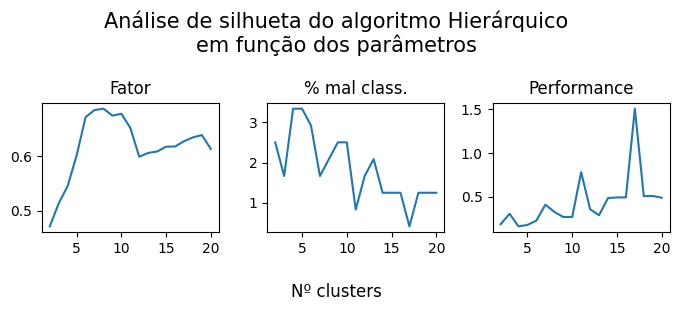

In [178]:
hierarquico = aplicar_algoritmo_em_range('AgglomerativeClustering', dados_pca, {'n_clusters': (2,20)})
sil_hierarquico = pegar_silhuetas(hierarquico, dados_pca)
analise_hierarquico = metricas_silhuetas(sil_hierarquico, 'Hierárquico')
analise_hierarquico

Vemos que o fator de silhueta cresce acentuadamente com o número de clusters até cerca de $6$ clusters, permanecendo estatisticamente estável entre $6$ e $7$ e depois decrescendo. O percentual de mal cassificados se encontra bem comportado em todo o espectro ($<5%$), decrescendo periodicamente. A performance sobe periodica e paulatinamente até um pico para $17$ clusters.

Embora um maior número de clusters ($>10$) leve a melhores métricas na performance e no percentual de mal classificados, há nessa região uma queda apreciável do fator de silhueta, principal indicacador usado aqui. Visto o percentual de mal classificados foi sempre baixo, adoto o princípio de Occam e **escolho a classificação com $6$ clusters como a melhor classificação do algoritmo Hierárquico**.

Abaixo, consolido essa escolha e ploto a classificação em função das três variáveis mais importantes para o PCA:

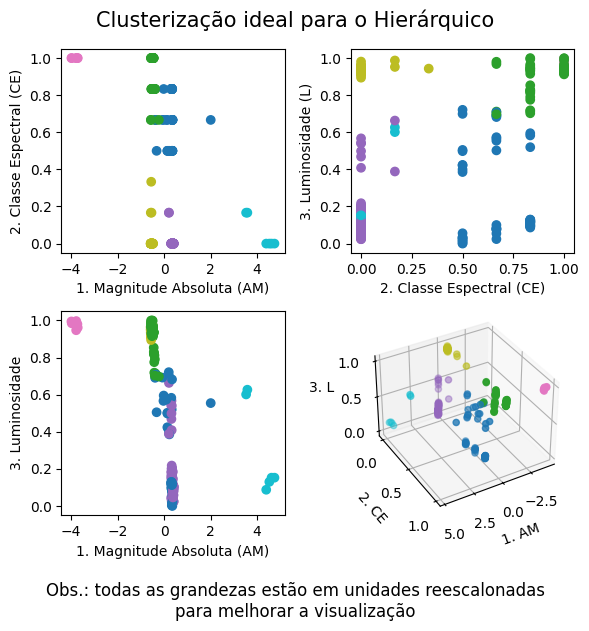

In [179]:
hierarquico_eleito = hierarquico[6]
plotar_clustering(hierarquico_eleito, 'Hierárquico')

Nota-se que o algoritmo foi capaz de fazer alguma diferenciação na região central da magnitude absoluta, o que indica que nosso preparo teve algum sucesso em suavizar a concentração dessa região. O plano entre classe espectral e luminosidade se mostrou importante para ajudar na separação desta região densa. Já a combinação de magnitude absoluta e ambas classe espectral e luminosidade evidenciou a existência de dois clusters muito distantes do restante dos dados, em regiões diagonais opostas no cubo do plot 3D.

#### 3.3) KMeans

O algoritmo KMeans recebe o mesmo parâmetro principal que o Hierárquico, o número de clusters que queremos impor. Usamos o mesmo espectro de valores para este parâmetro ($2$ a $20$):

C:\Users\henri\AppData\Local\Temp\ipykernel_105492\1961625255.py:78: RuntimeWarning: divide by zero encountered in divide
  metrica_performance = np.array(fator_silhueta) / np.array(perc_mal_classificados)


,Nº clusters,Fator,% mal class.,Performance
0,2,0.484892,0.000000,inf
1,3,0.525301,0.416667,1.260721
2,4,0.563797,0.000000,inf
3,5,0.585430,0.000000,inf
4,6,0.686283,0.000000,inf
5,7,0.657231,0.000000,inf
6,8,0.683638,0.416667,1.640731
7,9,0.687649,0.416667,1.650358
8,10,0.601234,0.833333,0.721481
9,11,0.604710,0.833333,0.725652


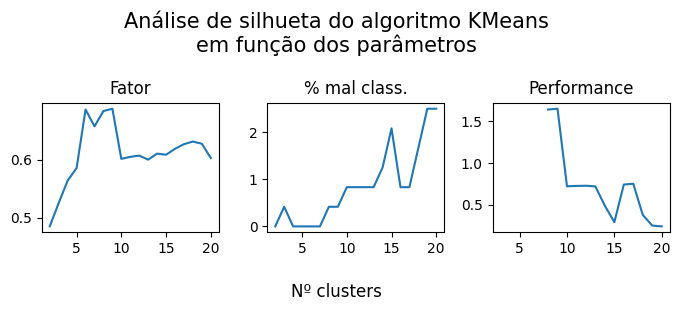

In [180]:
kmeans = aplicar_algoritmo_em_range('KMeans', dados_pca, {'n_clusters': (2,20)})
sil_kmeans = pegar_silhuetas(kmeans, dados_pca)
analise_kmeans = metricas_silhuetas(sil_kmeans, 'KMeans')
analise_kmeans

Notar que recebemos um aviso de divisão por zero, pois, nos primeiros números de clusters, o percentual de mal classificados foi zero, o que faz o indicador de performance ser infinito (e não aparecer no gráfico.)

O resultado desta análise é ainda mais claro, na medida em que o percentual de mal classificados e o indicador de performance passam a se deteriorar a partir do número $8$ de clusters. Os maiores fatores de silhueta, em patamar bem semelhante, são para $6$, $8$ e $9$. Pelo princípio de Occam e também pela deteriação dos demais indicadores, **escolho o número de $6$ clusters como melhor patamar para o KMeans**.

Consolidando e plotando:

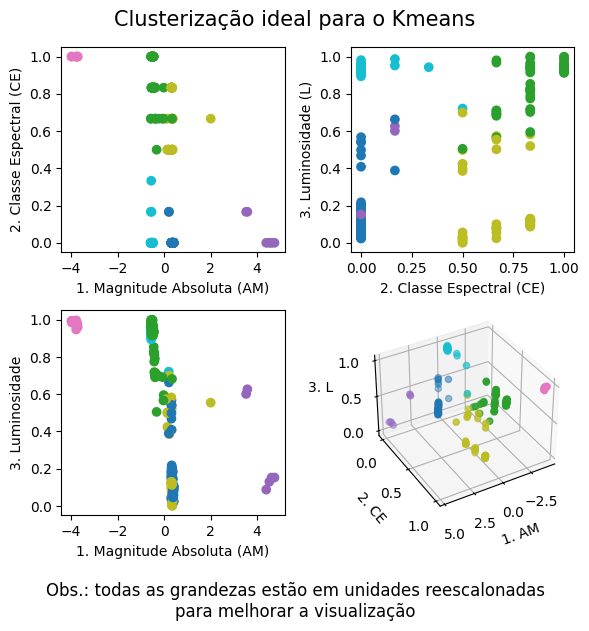

In [181]:
kmeans_eleito = kmeans[6]
plotar_clustering(kmeans_eleito, 'Kmeans')

Ao que parece, obtemos uma classificação muito parecida com a do algoritmo anterior. No tópico 4) abaixo poderemos quantificar essa semelhança.

#### 3.4) DBSCAN

Os parâmetros do DBSCAN são diferentes dos demais. Necessitamos especificar um `epsilon` ($\epsilon$), para a distância de *core*, e um parâmetro de `min_samples`, para definição da densidade na qual os pontos são considerados de fronteira.

Este algoritmo é extremamente sensível a esses parâmetros. Depois de tentar várias combinações e diferentes faixas de valores, escolhi a única faixa para a qual consegui fazer o algoritmo funcionar: $\epsilon \in (0,1; 0,2)$ e `min_samples` $\in (3, 10)$.

C:\Users\henri\AppData\Local\Temp\ipykernel_105492\1961625255.py:78: RuntimeWarning: divide by zero encountered in divide
  metrica_performance = np.array(fator_silhueta) / np.array(perc_mal_classificados)


,Parâmetros,Fator,% mal class.,Performance,Nº clusters,Nº outliers
0,e=0.1;ms=3,0.426325,18.333333,0.023254,13,37
1,e=0.1;ms=5,0.401419,22.083333,0.018177,10,49
2,e=0.1;ms=7,0.402013,27.500000,0.014619,7,66
3,e=0.1;ms=9,0.369920,29.583333,0.012504,7,71
4,e=0.4;ms=3,0.674102,0.000000,inf,3,3
5,e=0.4;ms=5,0.718368,0.416667,1.724083,2,7
6,e=0.4;ms=7,0.699866,5.416667,0.129206,1,13
7,e=0.4;ms=9,0.699866,5.416667,0.129206,1,13
8,e=0.7;ms=3,0.674102,0.000000,inf,3,3
9,e=0.7;ms=5,0.718368,0.416667,1.724083,2,7


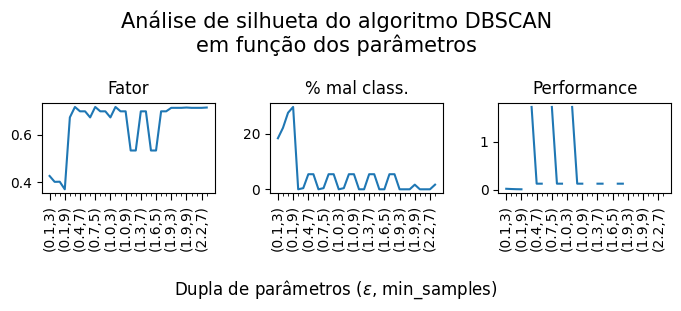

In [182]:
dbscan = aplicar_algoritmo_em_range('DBSCAN', dados_pca, {'eps': (0.1,2.2,0.3), 'min_samples': (3,10,2)})
sil_dbscan = pegar_silhuetas(dbscan, dados_pca)
analise_dbscan = metricas_silhuetas(sil_dbscan, 'DBSCAN', dbscan)
analise_dbscan

Novamente, recebemos um aviso de divisão por zero, devido a algumas combinações de fatores encontrarem zero pontos mal classificados.

Algumas faixas de combinações de parâmetros apresentaram um comportamento periódico. As primeiras faixas testadas, com $\epsilon = 0,1$ apresentaram desempenho ruim em todas as métricas. Outras duas faixas intermediárias tiveram uma baixa no fator de silhueta. De resto, este indicador ficou bastante estável e o percentual de mal classificados permaneceu bem comportado. **Elegi como melhor classificação o sexto conjunto testado, onde $(\epsilon,$`min_samples`$)$ foi igual a $(0,4;5)$** por ter apresentado o maior fator de silhueta junto com um número de mal classificados muito próximo de zero. (Os outros conjuntos que tiveram fator de silhueta em mesmo patamar parecem ter resultado em classificações idênticas a este.)

Abaixo, salvo o número de clusters obtido pelo conjunto escolhido, consolido este conjunto, e ploto:

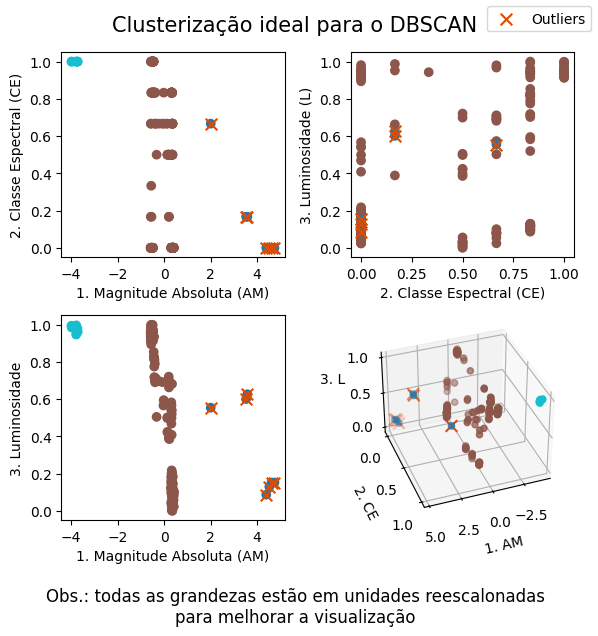

In [183]:
indice_fator_maximo = analise_dbscan['Fator'].idxmax()
numero_clusters = len(set(list(dbscan.values())[indice_fator_maximo]))
dbscan_eleito = dbscan['e=0.4;ms=5']
plotar_clustering(dbscan_eleito, 'DBSCAN', azim=70)

Além disso, no caso do DBSCAN, olharemos também para a presença de *outliers*. Notamos que a classificação escolhida identificou apenas $3$ clusters e $7$ *outliers*. Ao contrário dos demais algoritmos, o DBSCAN não foi capaz de discernir diferenças na faixa central dos valores de magnitude absoluta. Surpreendentemente, dentre os dois agrupamentos mais distantes neste quesito, apenas um deles foi tido como um cluster propriamente. Os *outliers* foram tidos como os pontos de maior magnitude absoluta, o que faz sentido porque os valores de magnitude absoluta dessa faixa são muito maiores do que costumam ser os objetos menos brilhantes.

---

### 4) Comparação

Este tópico responde a questão 8.

#### 4.1) A classificação dada

Por simplicidade, chamo de "Gabarito" a classificação dada pelo enunciado. Importando e inspecionando brevemente esta base de dados, vemos que há 6 clusters, o que indica que nossa análise com KMeans e Hierárquico pode ter sido razoável:

In [184]:
gabarito = pd.read_csv('dados/Categorias.csv')
print('Número de clusters do Gabarito:', len(set(gabarito['Type'])))

Número de clusters do Gabarito: 6


Repetindo o plot que fizemos para os resultados dos algoritmos:

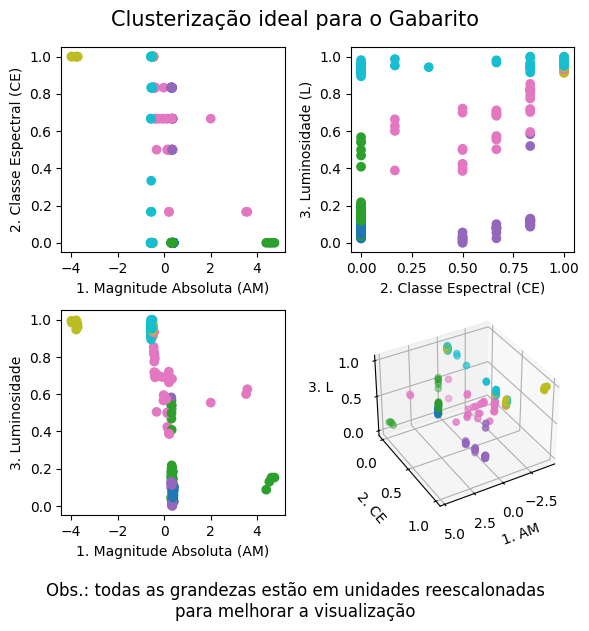

In [185]:
plotar_clustering(classificacao=gabarito['Type'], algoritmo='Gabarito')

Vê-se que a classificação manual conseguiu identificar mais variedade na região central da magnitude absoluta. Ainda, alguns objetos nos extremos da diagonal do cubo, que os nossos algoritmos classificaram como clusters à parte ou *outliers*, constam como estando no mesmo cluster de objetos da região central. Isso fortalece a tese de que pode ter havido algum tipo de preenchimento equivocado ou então de incostistência de escala nos dados de magnitude absoluta.

#### 4.2) Comparações numéricas

Ao comparar as classificações, existem algumas dificuldades:
* primeiro, mesmo que dois algoritmos cheguem a conclusões muito parecidas, é muito difícil que cheguem à exata mesma classificação para todos os pontos
* segundo, ainda que todo o resultado fosse igual, os números das categorias poderiam estar trocados

Isso dificulta a comparação numérica entre os resultados. Para resolver esse problema, defini abaixo algumas funções que comparam todos os conjuntos de categorias entre dois algoritmos. Por exemplo, o conjunto que o KMeans classificou como $0$ é comparado com o conjunto que o Hierárquico classificou como $0$, depois, com o conjunto que o Hierárquico classificou como $1$, e assim por diante, até abarcar todas as combinações possíveis. Para chegar a uma métrica razoável, tomei o número de elementos (cardinalidade) da interseção dos conjuntos comparados dividido pela cardinalidade da sua união, de modo que conjuntos totalmente idênticos têm nesse indicador $1$ (ou $100%$) e conjuntos totalmente diferentes têm nesse indicador $0$ (ou $0%$).

Chamo esta métrica de 'semelhança'. Ao maximizar a semelhança de um conjunto de um algoritmo ante os conjuntos de outro algoritmo, podemos identificar qual conjunto melhor corresponde ao outro, localizando, por exemplo, se dois clusters são idênticos a despeito de terem recebido números diferentes.

A função `comparar_classificacoes()` retorna um DataFrame com todas as comparações possíveis e a função `achar_mais_semelhante()` maximiza a semelhança para achar apenas os pares mais semelhantes, retornando um DataFrame com esses pares e seu score de semelhança:

In [186]:
from itertools import product

sets_hierarquico = {str(i): set(np.where(hierarquico_eleito == i)[0]) for i in range(6)}
sets_kmeans = {str(i): set(np.where(kmeans_eleito == i)[0]) for i in range(6)}
sets_dbscan = {str(i): set(np.where(dbscan_eleito == i-1)[0]) for i in range(numero_clusters)}
sets_gabarito = {str(i): set(np.where(gabarito['Type'] == i)[0]) for i in range(gabarito['Type'].max()+1)}

def comparar_classificacoes(sets_algoritmo1, sets_algoritmo2):
    """
    Calcula o indicador de semelhança entre todas as combinações de
    categorias definidas por dois algoritmos de clusterização.
    Retorna um DataFrame.
    """
    lista_classificacao1 = []
    lista_classificacao2 = []
    lista_semelhanca = []
    for combinacao in product(sets_algoritmo1, sets_algoritmo2):
        cardinalidade_intersecao = len(sets_algoritmo1[combinacao[0]] & sets_algoritmo2[combinacao[1]])
        cardinalidade_uniao = len(sets_algoritmo1[combinacao[0]] | sets_algoritmo2[combinacao[1]])
        lista_semelhanca.append(cardinalidade_intersecao / cardinalidade_uniao)
        lista_classificacao1.append(combinacao[0])
        lista_classificacao2.append(combinacao[1])
    df = pd.DataFrame({
        'Classificação 1': lista_classificacao1,
        'Classificação 2': lista_classificacao2,
        'Semelhança': lista_semelhanca
    })
    return df

def achar_mais_semelhante(comparacao):
    """
    A partir do retorno da função anterior, identifica quais categorias de cada
    algoritmo têm maior semelhança entre si.
    Retorna DataFrame com esse cálculo e o indicador de semelhança relevante.
    """
    categorias = list(set(comparacao['Classificação 1']))
    mais_semelhantes = []
    semelhancas = []
    for i in categorias:
        filtro = comparacao['Classificação 1'] == i
        comparacao_filtrada = comparacao[filtro]
        indice_procurado = comparacao_filtrada['Semelhança'].idxmax()
        mais_semelhantes.append(comparacao_filtrada['Classificação 2'][indice_procurado])
        semelhancas.append(str(round(comparacao_filtrada['Semelhança'][indice_procurado] * 100, 
        1)) + ' %')
    df = pd.DataFrame({
        'Classificação 1': categorias,
        'Classificação 2': mais_semelhantes,
        'Semelhança': semelhancas
    })
    return df

Comparo primeiro os resultados dos nossos algoritmos KMeans e Hierárquico, visto que eles haviam apresentado notável semelhança visual:

In [187]:
comparacao_hierarquico_kmeans = comparar_classificacoes(sets_hierarquico, sets_kmeans)
semelhantes_hierarquico_kmeans = achar_mais_semelhante(comparacao_hierarquico_kmeans)
semelhantes_hierarquico_kmeans

,Classificação 1,Classificação 2,Semelhança
0,2,0,100.0 %
1,5,2,100.0 %
2,1,1,89.4 %
3,4,5,97.1 %
4,3,3,100.0 %
5,0,4,86.0 %


De fato, os conjuntos são praticamente iguais, sendo idênticos em metade dos casos. Agora comparo cada algoritmo aplicado com a classificação manual do Gabarito:

In [188]:
comparacao_hierarquico_gabarito = comparar_classificacoes(sets_hierarquico, sets_gabarito)
semelhantes_hierarquico_gabarito = achar_mais_semelhante(comparacao_hierarquico_gabarito)
semelhantes_hierarquico_gabarito

,Classificação 1,Classificação 2,Semelhança
0,2,0,51.3 %
1,5,1,9.5 %
2,1,4,33.8 %
3,4,5,51.0 %
4,3,4,15.0 %
5,0,2,70.2 %


In [189]:
comparacao_kmeans_gabarito = comparar_classificacoes(sets_kmeans, sets_gabarito)
semelhantes_kmeans_gabarito = achar_mais_semelhante(comparacao_kmeans_gabarito)
semelhantes_kmeans_gabarito

,Classificação 1,Classificação 2,Semelhança
0,2,1,9.5 %
1,5,5,50.0 %
2,1,3,32.5 %
3,4,2,81.6 %
4,3,4,15.0 %
5,0,0,51.3 %


In [190]:
comparacao_dbscan_gabarito = comparar_classificacoes(sets_dbscan, sets_gabarito)
semelhantes_dbscan_gabarito = achar_mais_semelhante(comparacao_dbscan_gabarito)
semelhantes_dbscan_gabarito

,Classificação 1,Classificação 2,Semelhança
0,1,0,17.6 %
1,2,4,15.0 %
2,0,1,9.3 %


Fica evidente que a classificação do DBSCAN foi a mais discrepante. Julgo que este algoritmo não foi ideal para a tarefa, pois encontrou poucos clusters e não conseguiu diferenciar as estrelas na faixa de magnitude absoluta central, que são as mais comuns.

Para resumir os achados quanto às duas outras classificações, tiro a média  e mediana da semelhança:

In [191]:
semelhanca_hierarquico = [float(t.split('%')[0]) for t in semelhantes_hierarquico_gabarito['Semelhança']]
media_hierarquico = np.mean(semelhanca_hierarquico)
mediana_hierarquico = np.median(semelhanca_hierarquico)

semelhanca_kmeans = [float(t.split('%')[0]) for t in semelhantes_kmeans_gabarito['Semelhança']]
media_kmeans = np.mean(semelhanca_kmeans)
mediana_kmeans = np.median(semelhanca_kmeans)

print('Semelhança média entre Hierárquico e Gabarito:', round(media_hierarquico, 1), '%')
print('Semelhança mediana entre Hierárquico e Gabarito:', round(mediana_hierarquico, 1), '%')
print()
print('Semelhança média entre KMeans e Gabarito:', round(media_kmeans, 1), '%')
print('Semelhança mediana entre KMeans e Gabarito:', round(mediana_kmeans, 1), '%')

Semelhança média entre Hierárquico e Gabarito: 38.5 %
Semelhança mediana entre Hierárquico e Gabarito: 42.4 %

Semelhança média entre KMeans e Gabarito: 40.0 %
Semelhança mediana entre KMeans e Gabarito: 41.2 %


Como os algoritmos apresentaram resultado semelhante, sua comparação com o Gabarito também foi semelhante, sendo o KMeans um pouco mais próximo em média e o Hierárquico ligeiramente mais próximo em mediana. A comparação com a classificação manual me pareceu insatisfatória, não estando nem mesmo acima de $50%$. Vamos tentar visualizar o que pode ter acontecido por meio de um diagrama H-R.

#### 4.3) Diagrama H-R

O diagrama de Hertzsprung–Russell (H-R) é amplamente conhecido por permitir uma visualização de várias classificações de estrelas, cada uma com regiões características em um gráfico da magnitude absoluta pela temperatura (ou classe espectral).

Abaixo, ploto as classificações aqui comparadas no diagrama H-R. Notar que tive que que limitar o eixo vertical (magnitude absoluta), tendo em vista a existência de valores que fogem bastante da evidência experimental (reforçando novamente a possibilidade de erro).

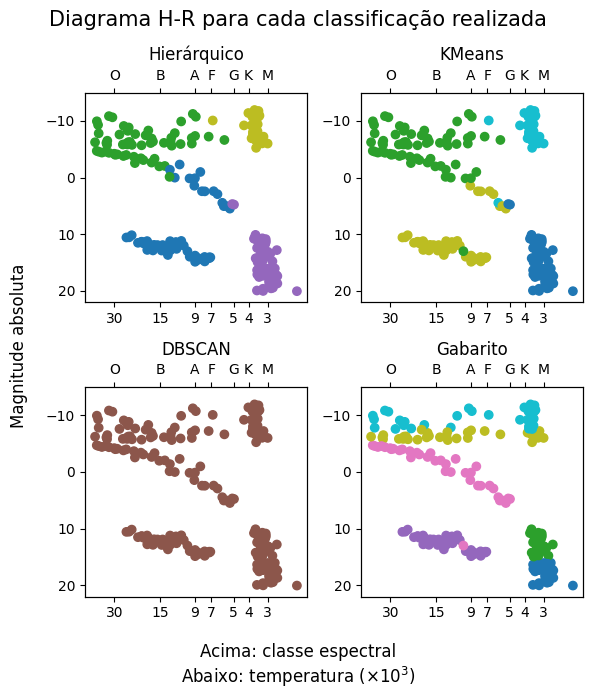

In [193]:
def HR_axes(ax, classificacao, algoritmo):
    # coordenadas dos pontos
    eixo_x = dados['Temperature']
    eixo_y = dados['A_M']

    # customizacao do eixo vertical
    ax.set_ylim(-15,22) # limitacao imposta ao eixo da magnitude absoluta
    ax.invert_yaxis()

    # plot dos dados
    ax.scatter(eixo_x, eixo_y, c=classificacao, cmap='tab10')
    
    # customizacao dos eixos horizontais
    ax.set_xscale('log')
    ax.invert_xaxis()
    ax_top = ax.twiny()
    ax_top.set_xscale('log')
    ax_top.set_xlim(ax.get_xlim())
    x_ticks = [30000, 15000, 9000, 7000, 5000, 4000, 3000]
    x_ticklabels = [round(tick/1000) for tick in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticklabels)
    ax_top.set_xticks(x_ticks)
    ax_top.set_xticklabels(['O', 'B', 'A', 'F', 'G', 'K', 'M'])
    ax_top.tick_params(axis="x", which="minor", bottom=False, top=False)
    ax.tick_params(axis="x", which="minor", bottom=False, top=False)

    # titulo
    ax.set_title(algoritmo)

# plot geral
fig, axes = plt.subplots(2, 2, figsize=(6,7))
HR_axes(axes[0,0], hierarquico_eleito, 'Hierárquico')
HR_axes(axes[0,1], kmeans_eleito, 'KMeans')
HR_axes(axes[1,0], dbscan_eleito, 'DBSCAN')
HR_axes(axes[1,1], gabarito['Type'], 'Gabarito')
fig.suptitle('Diagrama H-R para cada classificação realizada', size=15)
fig.supylabel('Magnitude absoluta')
fig.supxlabel('Acima: classe espectral\nAbaixo: ' + r'temperatura ($\times 10^3$)')
plt.tight_layout()

O formato do diagrama é bem característico, com uma região para as anãs brancas (esquerda inferior), outra região para gigantes e supergigantes (superior e direita superior), e um arco central, mais ou diagonal, para a sequência principal.

A classificação do Gabarito encontra $6$ grupos nessa área delimitada pelo gráfico. Separa a sequência principal em três conjuntos, sendo dois no canto inferior direito para as anãs vermelhas e um para o restante da sequência principal. Ela também separa as gigantes em dois grupos mais ou menos verticalmente quanto à magnitude absoluta, presumivelmente supergigantes vs gigantes. Por fim, como sexto cluster, o Gabarito separa as anãs brancas.

Já as nossas classificações KMeans identificam apenas $4$ grupos na área do gráfico. Os dois outros clusters que essas classificações encontraram não estão na área de plotagem, apresentando valores muito altos ou muito baixos para a magnitude absoluta, como vimos. Para as anãs vermelhas, tais classificações reservam um único grupo, o que considero positivo. A sequência principal, porém, fica repartida entre o grupo das anãs brancas e um dos grupos das gigantes. Por fim, estas últimas não estão separadas verticalmente entre gigantes e supergigantes, mas sim horizontalmente entre gigantes de alta temperatura ou coloração azulada e gigantes de baixa temperatura ou coloração avermelhada.

Apesar dessa discrepância entre as classificações, considero que a classificação dos algoritmos KMeans e Hierárquico têm suas virtudes, especialmente o algoritmo KMeans. Este algoritmo classificou apenas poucas estrelas da sequência principal fora do grupo das anãs brancas. Além disso, foi capaz de capturar diferenças entre as gigantes vermelhas e azuis, que de fato representam fases evolutivas diferentes na vida estelar, algo que a classificação manual não parece levar em conta.

Para testes futuros, creio que algumas medidas poderiam ajudar a separar melhor a sequência principal das demais categorias, principalmente preparar melhor os dados para: (i) ter certeza de eventuais imprecisões na magnitude absoluta; e (ii) reescalar melhor o raio e a luminosidade, proporcionando maior relevância a essas variáveis e permitindo uma separação melhor entre anãs, sequência principal e gigantes.

